In [29]:
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 10,6
#Dependencies
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [5]:
path = "../submission/datasets/"
#check location of files
os.getcwd()

'/Users/jacosta3/OneDrive - University of South Florida/Gerdau Projects/pft/scripts'

In [6]:
weekly = pd.read_csv(path + "structuralweekly_with_indicators.csv")

In [7]:
weekly.calendar_day = weekly.calendar_day.astype('datetime64')

In [8]:
# Splitting by years with uneven data points per year
# Source: https://stackoverflow.com/questions/58069691/how-to-create-a-train-test-split-of-time-series-data-by-year
year_list = weekly['year'].unique().tolist()
weekly_splits = {'train': [], 'test': []}

for idx, yr in enumerate(year_list[:-1]):
    train_yr = year_list[:idx+1]
    test_yr = [year_list[idx+1]]
    print('TRAIN: ', train_yr, 'TEST: ',test_yr)

    weekly_splits['train'].append(weekly.loc[weekly.year.isin(train_yr), :])
    weekly_splits['test'].append(weekly.loc[weekly.year.isin(test_yr), :])

print('\n')
# Exception, we only have 3 series (2019 + 2020) should be aggregated(if 2020 is used)
print("Size of the Train-Test Splits:")
print("Train 2016-18:",weekly_splits['train'][2].shape[0])
print("Test  2019-20:",weekly_splits['test'][2].shape[0]+weekly_splits['test'][3].shape[0])

TRAIN:  [2016] TEST:  [2017]
TRAIN:  [2016, 2017] TEST:  [2018]
TRAIN:  [2016, 2017, 2018] TEST:  [2019]
TRAIN:  [2016, 2017, 2018, 2019] TEST:  [2020]


Size of the Train-Test Splits:
Train 2016-18: 9455
Test  2019-20: 3064


In [9]:
train = weekly_splits['train'][2]
test = weekly_splits['test'][2].append(weekly_splits['test'][3], ignore_index=True)

In [10]:
#filtering block for analysis
train_block = train[train['block']=='4" ANG']
test_block = test[test['block']=='4" ANG']
#size decreases significantly - this could help/hurt
train_block.shape

(157, 18)

In [11]:
train_block.head()

,calendar_day,year,month,global_steel_utilization,fed_construction$B,state_local_construction$B,carbon_bar_ship_usa,carbon_bar_ship_canada,structural_ship_usa,structural_ship_canada,ism_manufacturing,ism_non_manufacturing,chicago_scrap$ST,block,inventory_tons,production_tons,sale_order_tons,shipment_tons
16,2016-01-03,2016,1,0.66,1583,16684,204300,30800,175300,38700,48.2,53.5,180,"4"" ANG",719.151,0,0.000,0
76,2016-01-10,2016,1,0.66,1583,16684,204300,30800,175300,38700,48.2,53.5,180,"4"" ANG",13147.336,3607,476.854,297
112,2016-01-17,2016,1,0.66,1583,16684,204300,30800,175300,38700,48.2,53.5,180,"4"" ANG",17879.528,0,620.538,937
166,2016-01-24,2016,1,0.66,1583,16684,204300,30800,175300,38700,48.2,53.5,180,"4"" ANG",14607.058,0,203.390,392
191,2016-01-31,2016,1,0.66,1583,16684,204300,30800,175300,38700,48.2,53.5,180,"4"" ANG",12144.329,1,455.771,696


In [12]:
test_block.head()

,calendar_day,year,month,global_steel_utilization,fed_construction$B,state_local_construction$B,carbon_bar_ship_usa,carbon_bar_ship_canada,structural_ship_usa,structural_ship_canada,ism_manufacturing,ism_non_manufacturing,chicago_scrap$ST,block,inventory_tons,production_tons,sale_order_tons,shipment_tons
21,2019-01-06,2019,1,0.7768,1601,18166,222800,34800,201600,34200,56.6,56.7,375,"4"" ANG",4262.897998,-24,159.2460,53
85,2019-01-13,2019,1,0.7768,1601,18166,222800,34800,201600,34200,56.6,56.7,375,"4"" ANG",5933.199996,0,99.4880,120
163,2019-01-20,2019,1,0.7768,1601,18166,222800,34800,201600,34200,56.6,56.7,375,"4"" ANG",9409.983072,4038,66.6380,190
213,2019-01-27,2019,1,0.7768,1601,18166,222800,34800,201600,34200,56.6,56.7,375,"4"" ANG",29326.198250,1680,484.3780,296
249,2019-02-03,2019,2,0.7915,1785,18809,201900,30500,175600,30900,54.2,59.7,355,"4"" ANG",39356.174170,49,1174.3135,875


In [13]:
train_block = train_block[['calendar_day', 'shipment_tons']]

In [14]:
test_block = test_block[['calendar_day', 'shipment_tons']]

In [15]:
train_block=train_block.set_index('calendar_day')
test_block=test_block.set_index('calendar_day')

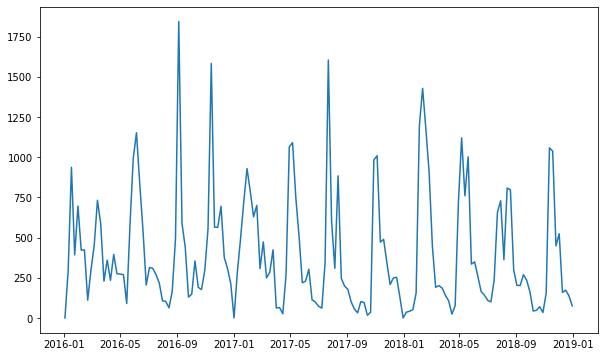

In [16]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.plot(train_block)

In [19]:
#to check if the data is stationary
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    #dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

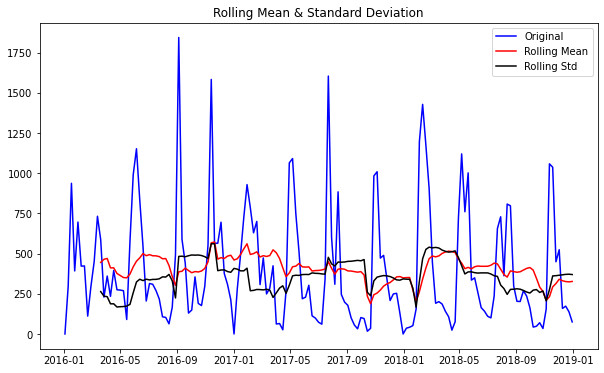

Results of Dickey-Fuller Test:
Test Statistic                -7.561664e+00
p-value                        2.998821e-11
#Lags Used                     7.000000e+00
Number of Observations Used    1.490000e+02
Critical Value (1%)           -3.475018e+00
Critical Value (5%)           -2.881141e+00
Critical Value (10%)          -2.577221e+00
dtype: float64


In [20]:
test_stationarity(train_block)

In [21]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(train_block, nlags=20)
lag_pacf = pacf(train_block, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

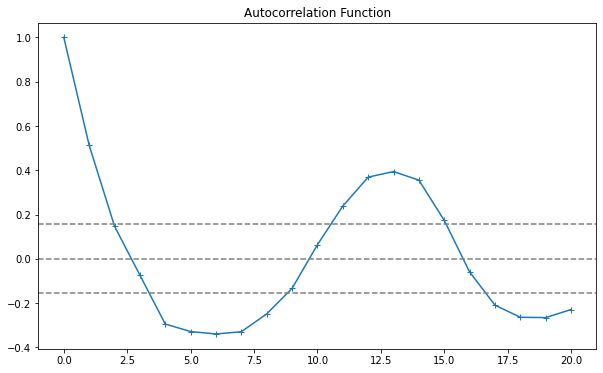

In [22]:
#Plot ACF: 
#plt.subplot(121) 
plt.plot(lag_acf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_block)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_block)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

Text(0.5, 1.0, 'Partial Autocorrelation Function')

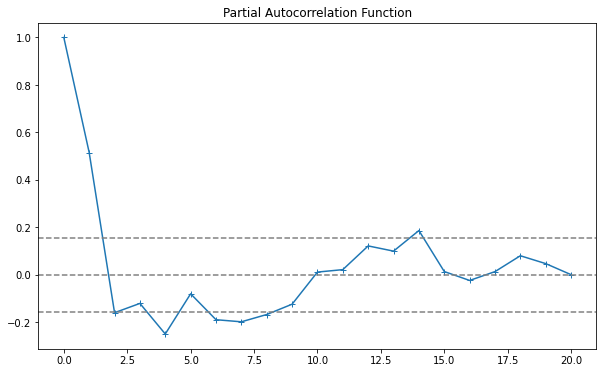

In [23]:
#Plot PACF:
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_block)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_block)),linestyle='--',color='gray')
def score_model(model, test_y, test_x=None, start=None, end=None, api=None):
    '''
    scoring function to be used across models
    parameters - 
        test_y: dataframe with dependent located in the last row
        test_x: dataframe with independent variables for model ingestion
        model: trained model
        start: if using ARMA, the start date in weekly time string format i.e. '2000-01-01'
        end: if using ARMA, then end date in weekly time string format i.e. '2001-01-01'
   …or(test_y, pred_y, squared=False)
    four_pred = pred_y[4:] if api != 'tf' else pred_y
    four_test = test_y[4:] if api != 'tf' else test_y
    print("Test Scores:", )
    print("  Mean Absolute Error(MAE):",mae)
    print("  Root Mean Squared Error(RMSE):",rmse)
    print("  Coefficient of Determination(R2):",r2)
    print("Take 4 Sample Comparison:")
    print("  Predictions:", four_pred[0:4].round().astype(int).transpose())
    print("      Actuals:", four_test[0:4].astype(int).transpose())ation Function')

/Users/jacosta3/.local/share/virtualenvs/pft-FTlP17jZ/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 14659481.6901')

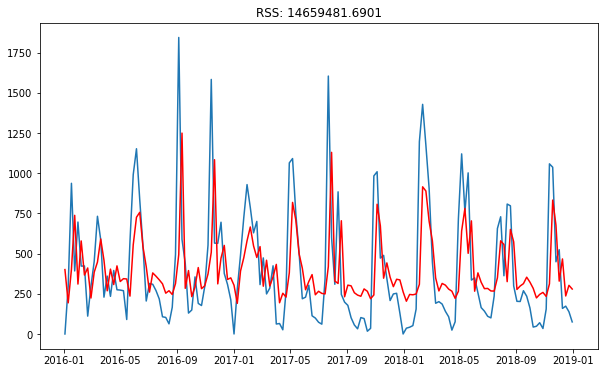

In [25]:
# ARIMA model
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
model = ARMA(train_block, order=(2,0,2))  
results_AR = model.fit(disp=-1)  
plt.plot(train_block)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-train_block['shipment_tons'])**2))

In [37]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_ARIMA_diff.tail())

calendar_day
2018-12-02    328.628989
2018-12-09    466.632026
2018-12-16    236.383354
2018-12-23    302.571068
2018-12-30    279.414083
dtype: float64


Text(0.5, 1.0, 'RMSE: 305.5691')

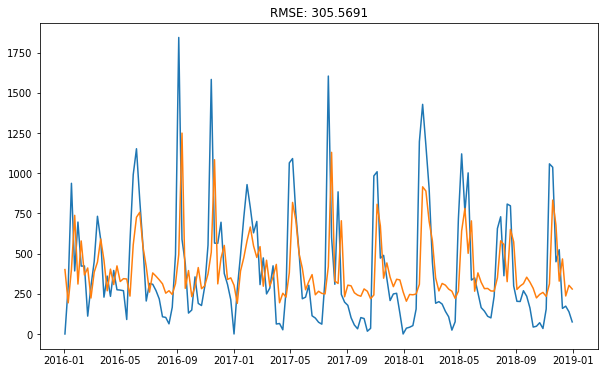

In [27]:
plt.plot(train_block)
plt.plot(predictions_ARIMA_diff)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_diff-train_block['shipment_tons'])**2)/len(train_block['shipment_tons'])))

In [65]:
y_pred=results_AR.predict(start='2019-01-06', end='2020-01-05')

In [81]:
y_pred.to_numpy()

array([247.26651252, 360.30734622, 400.65150595, 406.88391595,
       404.22253505, 401.64315999, 400.52152326, 400.2590227 ,
       400.27963044, 400.33353663, 400.36252319, 400.37132692,
       400.37200281, 400.37101276, 400.37031339, 400.37005179,
       400.37000605, 400.37002013, 400.37003579, 400.37004293,
       400.37004472, 400.37004466, 400.37004434, 400.37004416,
       400.3700441 , 400.3700441 , 400.3700441 , 400.37004411,
       400.37004411, 400.37004411, 400.37004411, 400.37004411,
       400.37004411, 400.37004411, 400.37004411, 400.37004411,
       400.37004411, 400.37004411, 400.37004411, 400.37004411,
       400.37004411, 400.37004411, 400.37004411, 400.37004411,
       400.37004411, 400.37004411, 400.37004411, 400.37004411,
       400.37004411, 400.37004411, 400.37004411, 400.37004411,
       400.37004411])

In [66]:
mean_absolute_error(test_block['shipment_tons'], y_pred)

245.88136175287087

In [67]:
mean_squared_error(test_block['shipment_tons'], y_pred, squared=False)

303.64437080385625

In [68]:
r2_score(test_block['shipment_tons'], y_pred)

0.015515928506312893

In [82]:
def score_model(model, test_y, test_x=None, start=None, end=None, api=None):
    '''
    scoring function to be used across models
    parameters - 
        test_y: dataframe with dependent located in the last row
        test_x: dataframe with independent variables for model ingestion
        model: trained model
        start: if using ARMA, the start date in weekly time string format i.e. '2000-01-01'
        end: if using ARMA, then end date in weekly time string format i.e. '2001-01-01'
        api: 'tf':tensorflow, 'prophet':facebook prophet, 'arma':statsmodel ARMA
    notes:
        For prophet input the 'future' df as test_x, that function will filter out the needed dataframe. For arma input the         start and end dates of prediction
    '''
    try:
        test_y = test_y.iloc[:,-1].to_numpy()
    except:
        print('test_y is a numpy array')
    if api == 'arma':
        pred_y = model.predict(start=start, end=end).to_numpy()
    elif api == 'tf':
        pred_y = scale.inverse_transform(model.predict(test_x))[:,-1]
        test_y = scale.inverse_transform(test_y)
    elif api == 'prophet':
        forecast = prophet.predict(test_x)
        pred_y = forecast[forecast['ds'].dt.year >=2019][['ds','yhat']].rename(columns={'yhat':'y'}).iloc[:,-1].to_numpy()
    else:
        pred_y = model.predict(test_x)
    r2 = r2_score(test_y, pred_y)
    mae = mean_absolute_error(test_y,pred_y)
    rmse = mean_squared_error(test_y, pred_y, squared=False)
    four_pred = pred_y[4:] if api != 'tf' else pred_y
    four_test = test_y[4:] if api != 'tf' else test_y
    print("Test Scores:", )
    print("  Mean Absolute Error(MAE):",mae)
    print("  Root Mean Squared Error(RMSE):",rmse)
    print("  Coefficient of Determination(R2):",r2)
    print("Take 4 Sample Comparison:")
    print("  Predictions:", four_pred[0:4].round().astype(int).transpose())
    print("      Actuals:", four_test[0:4].astype(int).transpose())

In [83]:
score_model(results_AR,test_block, start='2019-01-06', end='2020-01-05', api='arma')

Test Scores:
  Mean Absolute Error(MAE): 245.88136175287087
  Root Mean Squared Error(RMSE): 303.64437080385625
  Coefficient of Determination(R2): 0.015515928506312893
Take 4 Sample Comparison:
  Predictions: [404 402 401 400]
      Actuals: [875 736 617 490]
